In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.signal as sg
import scipy.ndimage as img

from functions.functions import get_region_coords, region_contours
from functions.latex import set_size
from skimage import measure
from cartopy.util import add_cyclic_point



datadir = "../data/"
figdir = "../figures/"

In [4]:
ds = xr.open_dataset(datadir + "hydrography_woa_ease.nc")
ds

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


<xarray.Dataset> Size: 228MB
Dimensions:  (depth: 102, y: 264, x: 264)
Coordinates:
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    ct       (depth, y, x) float64 57MB ...
    sa       (depth, y, x) float64 57MB ...
    t_dd     (depth, y, x) float64 57MB ...
    s_dd     (depth, y, x) float64 57MB ...
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [5]:
mask = xr.open_dataarray(datadir + "arctic_ocean/contourmask_eff_1000.nc").squeeze().drop_vars("depth")
ds = ds.where(mask)

In [6]:
ds_sel = ds.sum(dim="depth", skipna=True)
ds_sel

<xarray.Dataset> Size: 1MB
Dimensions:  (y: 216, x: 121)
Coordinates:
  * x        (x) int64 968B 65 66 67 68 69 70 71 ... 179 180 181 182 183 184 185
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
    lat      (y, x) float32 105kB ...
    lon      (y, x) float32 105kB ...
Data variables:
    ct       (y, x) float64 209kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sa       (y, x) float64 209kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    t_dd     (y, x) float64 209kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    s_dd     (y, x) float64 209kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [7]:
region_name = "arctic_ocean"
region = get_region_coords(region_name)
region

[-180, 180, 60, 90]

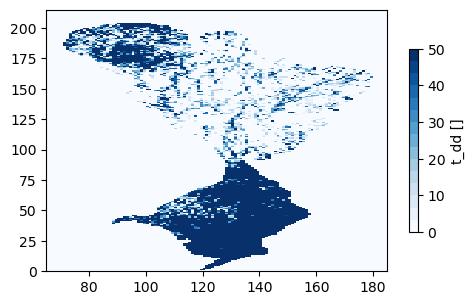

In [8]:
fig, ax = plt.subplots(1, 1,
                       figsize=set_size(width="AGU")
                       )
cmap = plt.get_cmap('Blues', 15)

c = ax.pcolormesh(ds_sel.x, ds_sel.y, ds_sel.t_dd.isel(x=slice(0, -1), y=slice(0, -1)),
                  vmin=0,
                  vmax=50,
                  cmap=cmap
                  )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

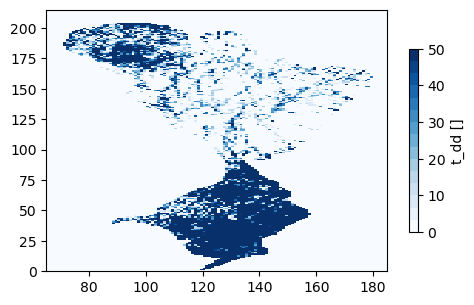

In [9]:
fig, ax = plt.subplots(1, 1,
                       figsize=set_size(width="AGU")
                       )
cmap = plt.get_cmap('Blues', 15)

c = ax.pcolormesh(ds_sel.x, ds_sel.y, ds_sel.s_dd.isel(x=slice(0, -1), y=slice(0, -1)),
                  vmin=0,
                  vmax=50,
                  cmap=cmap
                  )
fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

6.222103542473633
3200.0
3300.0


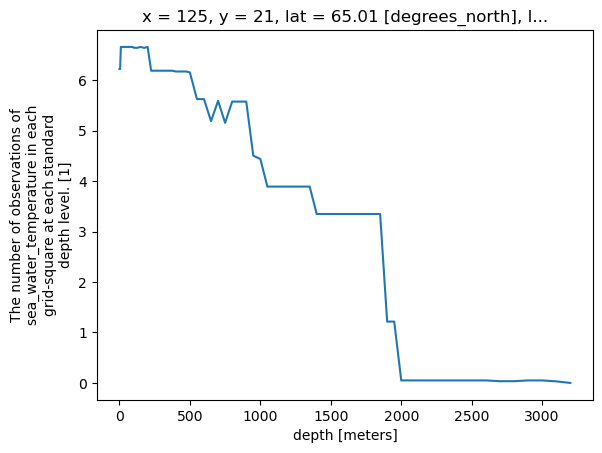

In [10]:
y_sel, x_sel = 21, 125
var_sel = ds.t_dd.sel(y=y_sel, x=x_sel, method="nearest")
var_sel.plot()
print(var_sel.sel(depth=0, method="nearest").values)
print(var_sel.idxmin().values)
print(var_sel.isnull().idxmax().values)

In [11]:
lat_sel, lon_sel = 30, 125
var_sel = ds.t_dd.sel(y=y_sel, x=x_sel, method="nearest")
if var_sel.min() < 1e-4:
    depth_obs = var_sel.idxmin().values
    depth = var_sel.isnull().idxmax().values
print(f"depth_obs = {depth_obs}")
print(f"depth = {depth}")
D = (depth_obs + depth)/(2*depth)
print(D)

depth_obs = 3200.0
depth = 3300.0
0.9848485


In [12]:
y_sel, x_sel = 21, 125
var_sel = ds.t_dd.sel(y=y_sel, x=x_sel, method="nearest")
if var_sel.min() < 1e-4:
    depth = var_sel.isnull().idxmax().values
    depth_obs = var_sel.idxmin().values
else:
    depth = var_sel.isnull().idxmax().values
    depth_obs = depth
print(f"depth_obs = {depth_obs}")
print(f"depth = {depth}")
D = (depth_obs + depth)/(2*depth)
print(D)

depth_obs = 3200.0
depth = 3300.0
0.9848485


In [13]:
D_array = np.zeros((len(ds.y), len(ds.x)))
for i, y_sel in enumerate(ds.y):
    for j, x_sel in enumerate(ds.x):
        var_sel = ds.t_dd.sel(y=y_sel, x=x_sel, method="nearest")
        depth = var_sel.isnull().idxmax()
        if depth > 0:
            if var_sel.min() < 1e-4:
                depth_obs = var_sel.idxmin()
            else:
                depth_obs = depth
            D = 1 - (depth - depth_obs)/depth
        else:
            D = np.nan
        D_array[i, j] = D

In [14]:
ds_D = xr.DataArray(D_array, 
                    coords={"y": ds.y, "x": ds.x, "lat" : ds.lat, "lon" : ds.lon}, 
                    dims=["y", "x"],
                    name="D"
                   )
ds_D

<xarray.DataArray 'D' (y: 216, x: 121)> Size: 209kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
  * x        (x) int64 968B 65 66 67 68 69 70 71 ... 179 180 181 182 183 184 185
    lat      (y, x) float32 105kB ...
    lon      (y, x) float32 105kB ...

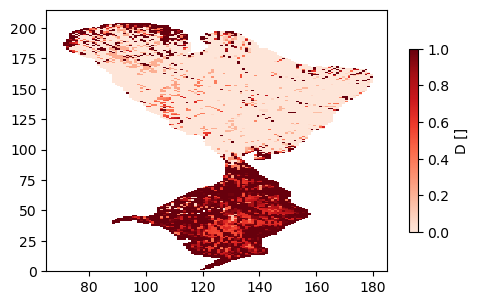

In [15]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds')
cmap = truncate_colormap(cmap, minval=0.1, maxval=1.0)

fig, ax = plt.subplots(1, 1,
                       figsize=set_size(width="AGU")
                       )

c = ax.pcolormesh(ds_D.x, ds_D.y, ds_D.isel(x=slice(0, -1), y=slice(0, -1)),
                  vmin=0,
                  vmax=1,
                  cmap=cmap
                  )

fig.colorbar(c,
             label="D []",
             shrink=0.7
            )

In [16]:
depth_field = ds.t_dd.isnull().idxmax(dim="depth")
depth_field

<xarray.DataArray 'depth' (y: 216, x: 121)> Size: 105kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * x        (x) int64 968B 65 66 67 68 69 70 71 ... 179 180 181 182 183 184 185
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
    lat      (y, x) float32 105kB ...
    lon      (y, x) float32 105kB ...

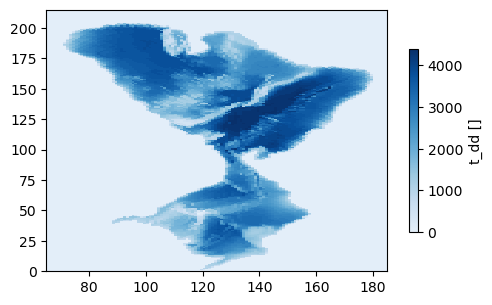

In [17]:
fig, ax = plt.subplots(1, 1,
                       figsize=set_size(width="AGU")
                       )

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
cmap = truncate_colormap(cmap, minval=0.1, maxval=1.0)

c = ax.pcolormesh(depth_field.x, depth_field.y, depth_field.isel(x=slice(0, -1), y=slice(0, -1)),
                  vmin=0,
                  vmax=4400,
                  cmap=cmap
                  )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

In [18]:
ds.t_dd.sum(dim="depth").where(depth_field == ds.isel(depth=-6).depth).max()

<xarray.DataArray 't_dd' ()> Size: 8B
array(nan)
Coordinates:
    depth    float32 4B 5e+03

In [19]:
n_array = np.zeros(len(ds.depth))
for i, d in enumerate(ds.depth):
    val = ds.t_dd.where(depth_field == ds.isel(depth=i).depth).sum(dim="depth").max()
    if ~np.isnan(val) and val > 0:
        n_array[i] = val
    else:
        n_array[i] = np.nan
ds_n = xr.DataArray(n_array, 
                    coords={"depth" : ds.depth}, 
                    dims=["depth"]
                   )
ds_n

<xarray.DataArray (depth: 102)> Size: 816B
array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,    9.47881085,           nan,   24.50524815,
                 nan,   34.4830108 ,           nan,           nan,
                 nan,           nan,           nan,   13.02105375,
                 nan,   27.08532545,  131.78315401,  795.11779869,
        201.3559318 ,  448.20270773,  113.41747749, 1444.30405208,
                 nan,  128.16571413,  104.21637984,  522.51936054,
        102.83438785,  710.31264277,  324.84357918, 1213.00201602,
        421.03776701,  322.93536379, 1509.65469118, 1143.72923898,
        468.19155083, 3131.55388666, 1660.90776347, 4352.28336707,
        822.42965343, 5524.39858876, 1929.60963494, 5102.92624464,
       1503.50029508, 1596.65531183, 3052.54146398, 4293.84386428,
        752.79241246,  849.72664652, 1308.43436178, 1032.63844576,
       2384.55434717,  467.69801428,  710.85038787, 1427.79787412,
       1340.26010288, 7723.30951464,  721.16296724, 6060.2996585 ,
       1113.16319704, 1083.05545842,  656.62515272, 2491.43678102,
        985.57946747,  672.32815006,  858.18574318, 2479.20664806,
        747.91039112, 1541.33285861, 4377.00854763, 1465.23525671,
       2857.56282679,  831.54099561,  766.47941095,  924.31871825,
        670.83494806,  615.62361648, 1114.25643397, 1386.13763157,
        491.98005211,  250.51665068,   57.40679354,   51.50488419,
         70.32732763,   73.54345443,   83.654584  ,   40.        ,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan])
Coordinates:
  * depth    (depth) float32 408B 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03

In [20]:
nobs = ds.t_dd
da_list = []
for i, d in enumerate(nobs.depth):
    da = xr.where(depth_field == d, nobs/ds_n.isel(depth=i), 0).sum(dim="depth", skipna=True)
    da_list.append(da)
da_nobs = xr.DataArray(np.sum(da_list, axis=0), 
                    coords={"y": ds.y, "x": ds.x, "lat" : ds.lat, "lon" : ds.lon}, 
                    dims=["y", "x"],
                    name="N"
                   )
da_nobs

<xarray.DataArray 'N' (y: 216, x: 121)> Size: 209kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
  * x        (x) int64 968B 65 66 67 68 69 70 71 ... 179 180 181 182 183 184 185
    lat      (y, x) float32 105kB ...
    lon      (y, x) float32 105kB ...

In [21]:
da_nobs.max()

<xarray.DataArray 'N' ()> Size: 8B
array(1.)

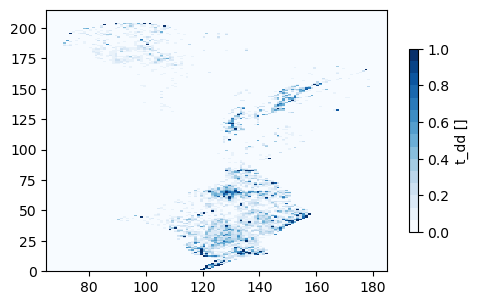

In [22]:
fig, ax = plt.subplots(1, 1,
                        figsize=set_size(width="AGU")
                        )
cmap = plt.get_cmap('Blues', 15)

c = ax.pcolormesh(da_nobs.x, da_nobs.y, da_nobs.isel(x=slice(0, -1), y=slice(0, -1)),
                  vmin=0,
                  vmax=1,
                  cmap=cmap
                  )

fig.colorbar(c,
             label="t_dd []",
             shrink=0.7
            )

In [23]:
ds_index = (da_nobs.where(da_nobs > 0) + ds_D)/2
ds_index.name = "ND"
ds_index

<xarray.DataArray 'ND' (y: 216, x: 121)> Size: 209kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 208 209 210 211 212 213 214 215
  * x        (x) int64 968B 65 66 67 68 69 70 71 ... 179 180 181 182 183 184 185
    lat      (y, x) float32 105kB 56.51 56.61 56.72 56.82 ... 67.89 67.77 67.65
    lon      (y, x) float32 105kB -26.83 -26.48 -26.13 ... 148.3 147.8 147.4

In [24]:
ds_index.max()

<xarray.DataArray 'ND' ()> Size: 8B
array(1.)

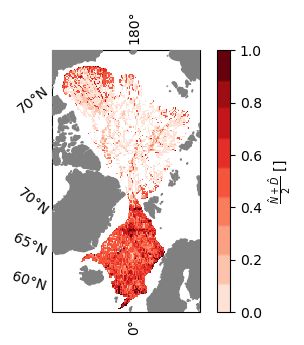

In [25]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Reds', 10)
cmap = truncate_colormap(cmap, minval=0.1, maxval=1.0)

fig, ax = plt.subplots(1, 1,
                        figsize=set_size(width="AGU"),
                        subplot_kw={"projection" : ccrs.Stereographic(central_latitude=90)}
                        )

c = ax.pcolormesh(ds_index.lon, ds_index.lat, ds_index,
                  transform=ccrs.PlateCarree(),
                  vmin=0,
                  vmax=1,
                  cmap=cmap
                  )
ax.add_feature(cfeature.LAND, color="grey", zorder=100)
gl0 = ax.gridlines(draw_labels=True, zorder=1, y_inline=False)
gl0.xlines = False
gl0.ylines = False
gl0.right_labels = False
fig.colorbar(c,
             label=r"$\frac{\hat{N} + \hat{D}}{2}$ []",
             pad=0.04
            )
fig.savefig(figdir + "data_coverage.pdf", dpi=600, bbox_inches="tight")

In [44]:
ds_sel.t_dd.to_netcdf(datadir + "nobservations_woa.nc")